# Import packages

In [1]:
import re
import os
import itertools as its
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import glob
import scipy as sp
from pandas.io.pytables import HDFStore
import math
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

plt.style.use('seaborn-notebook')

In [2]:
from sphandles.sphandle import sphandle
from sphandles.ML_Train import mltrain

# Define Functions

In [3]:
def parse_filename(fname):
    pattern = ".*__(\w+).csv"
    m = re.match(pattern, fname)
    return m.group(1)

def read_csv(fname,dropcols=None):
    dropcols = dropcols if dropcols else []
    label = parse_filename(fname)
    df = pd.read_csv('./{}'.format(fname),
                    index_col=0)
    df = df[[c for c in df.columns if c.endswith('mass_g') and c not in dropcols]].fillna(0.0)
    df.columns = df.columns.str.replace('_mass_g','')
    df = df[abs(df).T.sum() > 0].reset_index(drop=True)
    df[df < 0] = 0
    df['label'] = label
    df = df.set_index('label')
    return df, label

def pca_analysis(df, label):
    pca = PCA()
    X = pca.fit_transform(df)
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    fig, ax = plt.subplots()
    ax.plot(x1, x2, '.')
    ax.set(
        xlabel="First component",
        ylabel="Second component",
        title="%s: projected onto first two components" % label,
    )
    
    components = pd.DataFrame(pca.components_.T, index=df.columns)
    print_until = 0.9999
    cumulative_explained_variance = 0
    i = 0
    while cumulative_explained_variance < print_until:
        explained = pca.explained_variance_ratio_[i]
        print("=> COMPONENT %d explains %0.2f%% of the variance" % (i, 100*explained))
        top_components = components[i].sort_values(ascending=False)
        top_components = top_components[abs(top_components) > 0.0]
        print(top_components)
        i += 1
        cumulative_explained_variance += explained
    return components

# TODO
def nmf_analysis(df, label):
    nmf = NMF(components=2)
    X = nmf.fit_transform(df)
    x1 = X[:, 0]
    x2 = X[:, 1]
    fig, ax = plt.subplots()
    ax.plot(x1, x2, '.')
    ax.set(
        xlabel="First component",
        ylabel="Second component",
        title="%s: projected onto first two components" % label,
    )
    error = nmf.reconstruction_err_ / float(len(df))
    components = pd.DataFrame(nmf.components_.T, index=df.columns)

def load_and_analyze(filenames, dropcols=None):
    for filename in filenames:
        df, label = read_csv(filename, dropcols)
        print("== %s ==" % label)
        components = pca_analysis(df, label)
        print()
        
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, classes)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def evaluate_model(clf, df, labels):
    model_name = '->'.join(next(zip(*clf.steps)))
    print("Model: %s" % model_name)
    scores = cross_val_score(clf, df, labels, cv=3) #cv=TimeSeriesSplit(3))
    mean_score = scores.mean()
    std_score = scores.std()
    print("Accuracy: [%0.4f, %0.4f] (%0.4f +/- %0.4f)"
          % (mean_score - std_score, mean_score + std_score, mean_score, std_score))
    y_pred = cross_val_predict(clf, df, labels, cv=3)
    y_prob = cross_val_predict(clf, df, labels, cv=3, method='predict_proba')
    plot_confusion_matrix(labels, y_pred, labels.unique())
    return y_pred, y_prob, labels, df

def evaluate_modelrfe(clf, df, labels):
    model_name = '->'.join(next(zip(*clf.steps)))
    print("Model: %s" % model_name)
    scores = cross_val_score(clf, df, labels, cv=3)
    mean_score = scores.mean()
    std_score = scores.std()
    print("Accuracy: [%0.4f, %0.4f] (%0.4f +/- %0.4f)"
          % (mean_score - std_score, mean_score + std_score, mean_score, std_score))
    y_pred = cross_val_predict(clf, df, labels, cv=3)
    y_prob = cross_val_predict(clf, df, labels, cv=3, method='predict')
    return y_pred, y_prob, labels, df

#Type: Data Frame. From a selected isotope and its particle events, select all other isotopes associated and drop others not associated with it
def isotope_particle(data, isotope):
    obs = data[data[isotope] > 0.0]
    return obs

#Merging particle splits based on analyte
def merge_particles(df,dfc):
    index_selector = []
    for i in dfc.columns:
        index_selector1 = dfc[dfc[i].notnull()][i].cumsum()
        index_selector.append(index_selector1)
    dfcorrected = df.groupby(index_selector[13]).agg('sum').reset_index(drop=True).drop(columns = 'ID')
    dfcorrected = dfcorrected.replace(0, np.nan)
    return dfcorrected

#displays R-Sqr value for each dissolved calibration
def r_sqr_analyzer(data, R_value):
    c = data[data['r_sqr_counts'] < R_value]
    return c


#user function: loads a list of variable path names and assigns a label 
def load_and_label(pathname, newlabel):
    data1 = pd.DataFrame()
    for i in glob.glob(pathname):
        data, soil_label = read_csv(i,DROPCOLS)
        data1 = pd.concat([data,data1], axis = 0, sort=False)
    data1['newlabel'] = newlabel
    data1 = data1.set_index('newlabel')
    return data1

#bootstrapping method
# parsing DF for test dataset
def holdoutdata(df, perc):
    #making hold out data
    dfnat = df[df.index == 'Natural']
    dfeng = df[df.index == 'Engineered']

    msk = np.random.rand(len(dfnat)) < perc
    mske = np.random.rand(len(dfeng)) < perc
    holdoutdatanat = dfnat[~msk]
    holdoutdataeng = dfeng[~mske]
    trainingdatanat = dfnat[msk]
    trainingdataeng = dfeng[mske]

    #combining holdout data together and labels
    holdoutdata = pd.concat([holdoutdatanat, holdoutdataeng], axis=0)
    holdoutlabels = holdoutdata.index.get_level_values(level='newlabel')
    return holdoutdata, holdoutlabels, trainingdatanat, trainingdataeng

#bootstrapping process. Holdout some data, predict on it and do that N amount of times. Repeated this procedure M amount of times 
def bootstrap(df, N, m):
    #repeat this process M amount of times
    for _ in range(m):
        #holdout 20% of data. 
        holdoutdata, holdoutlabels, trainingdatanat, trainingeng = holdoutdata(df, 0.2)
        #create a NP array from 0.05 to 1.05 with 0.05 step increment
        p = np.arange(0.05, 1.05, 0.05)
        #create an empty dataframe
        df1 = pd.DataFrame()
        #for each 0.05 step from p
        for i in p:
            #create an empty list
            percent = []
            #repeat this N amount of times
            for _ in range(N):
                #sample an i fraction of the training data
                snat = trainingdatanat.sample(frac = i, replace = True)
                seng = trainingdataeng.sample(frac = i, replace = True)
                
                #combine training data and get traininglabels

                trainingdata = pd.concat([snat, seng], axis=0)
                traininglabels = trainingdata.index.get_level_values(level='newlabel')
                
                #create the logistic Regression model with 5-fold cross validation with NMF of 10 componenets
            
                clf = make_pipeline(
                    StandardScaler(with_mean=False),
                    NMF(n_components=10),
                    LogisticRegressionCV(cv=5, max_iter=300)
                )
                #fit with fraction of training set
                clf = clf.fit(trainingdata, traininglabels)
                #score with the heldout test set
                y_score = clf.score(holdoutdata, holdoutlabels)
                #append the score to percent
                percent.append(y_score)
                #put it in a dataframe format
                pcdf = pd.DataFrame(percent)
            df1 = pd.concat([df1, pcdf], axis = 1)
        
        df1.columns = np.arange(0.05, 1.05, 0.05)
        
        average = []
        stdev = []
        for i in df1.columns:
            average.append(df1[i].mean())
            stdev.append(df1[i].std())
        plt.errorbar(np.arange(0.05, 1.05, 0.05), average, yerr = stdev)
        plt.xlabel('% of training data')
        plt.ylabel('Accuracy of model (%)')

#return df_with_prob
def just_data(data):
    new = data.drop(columns = ['newlabel','Engineered','Natural','prob_obs_group'])
    return new

#marginal_probabilities returns out of the total particle events, what is the probability of an individual isotope occurring
def marginal_probabilities(data):
    #return data.count().sort_values(ascending=False) / total_particles(data).sum()
    return (abs(data) > 0.0).mean().sort_values(ascending=False)

#Counts total number of peaks for each isotope
def marginal_particle(data):
    return data[data > 0.0].count().sort_values(ascending=False)

def non_zero_data(data):
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#counts the total particles associated to an isotope
#conditional_probabilities returns out of the total selected-isotope particle events, what is the probability it is associated with the list of other isotopes 
def conditional_probabilities(data, isotope):
    obs = data[abs(data[isotope]) > 0.0]
    partners = (abs(obs) > 0.0).astype(np.float64).mean()
    return partners[abs(partners) > 0.0].sort_values(ascending=False)

#counts the total particles associated to an isotope
def conditional_particle(data, isotope):
    obs = data[abs(data[isotope]) > 0.0].count()
    return obs.sort_values(ascending=False)

#isotope_pure returns a data frame of the selected isotope particle event and its impurities
def isotope_pure(data, isotope):
    obs = data[data[isotope] > 0.0]
    others = obs.drop(columns=isotope)
    pure = others.sum(axis=1) == 0.0
    others = obs[pure]
    return others

#probability_pure returns out of the total selected-isotope particle events, what is the probability that it is not associated with any other isotope
def probability_pure(data, isotope):
    obs = data[data[isotope] > 0.0]
    others = obs.drop(columns=isotope)
    pure = (others.sum(axis=1) == 0.0).mean()
    return pure

#returns the same number of particles to the smallest dataframe
def sameamount(dfA, dfB):
    if len(dfA) > len(dfB):
        dfC = pd.concat([dfA[:len(dfB)], dfB], sort=False).fillna(0.0).clip(lower=0.0)
    else:
        dfC = pd.concat([dfA, dfB[:len(dfA)]], sort=False).fillna(0.0).clip(lower=0.0)

    labelsA = dfC.index.get_level_values(level='newlabel')
    return dfC, labelsA

def category_split(labeldf, label, upperbound, lowerbound):
        correct = labeldf[labeldf[label] > upperbound]
        uncertain = labeldf[labeldf[label] < upperbound]
        uncertain = uncertain[uncertain[label] > lowerbound]
        misclassified = labeldf[labeldf[label] < lowerbound]
        return [correct, uncertain, misclassified]
    
def graphmaker(df, label, upperbound, name, natdf, savefigs, opencircles = False):
    toppercent = conditional_probabilities(just_data(df[df[label] > upperbound]), '48Ti')
    bottompercent = conditional_probabilities(just_data(df[df[label] < upperbound]), '48Ti')
    percentdf = pd.DataFrame([toppercent, bottompercent]).T
    percentdf.columns = ['toppercent', 'bottompercent']
    percentdf.reset_index(inplace = True)
    percentdf = pd.melt(percentdf[1:13], id_vars = ['index'], value_vars = ['toppercent', 'bottompercent'])

    fig, axs = plt.subplots(1, 2, figsize=(16,4), dpi=300, gridspec_kw={'width_ratios': [2.5, 1]})
    ax1 = sns.barplot('index', 'value', 'variable', data = percentdf, ax = axs[0])
    ax1.set_ylabel('Isotope Frequency', fontsize = 16)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.set_xlabel('')
    ax1.set_ylim([10**-3, 1])
    ax1.legend_.remove()
    ax1.set_yscale('log')
    
    #if you want unassociated Ti as a separate category
    if opencircles == True:
        #make the df pure ti df
        Pure = isotope_pure(just_data(df).drop(columns = '46Ti'), '48Ti')
        percentdfpure = df.loc[Pure.index]
        df.drop(percentdfpure.index, inplace = True)
        
    #parse particles by confidence probability to the correct category
    top = df[df[label] > upperbound]
    puretop = percentdfpure[percentdfpure[label] > upperbound]
    bot = df[df[label] < upperbound]
    purebot = percentdfpure[percentdfpure[label] < upperbound]
   
    axs[1].scatter(bot['48Ti'], bot[label], linewidths = 0.75, edgecolors = 'white', facecolors = '#ff7f0e')
    axs[1].scatter(top['48Ti'], top[label], linewidths = 0.75, edgecolors = 'white', facecolors = '#1f77b4')
    axs[1].scatter(purebot['48Ti'], purebot[label], linewidths = 0.75, edgecolors = 'white', facecolors = '#ff7f0e', marker = '^')
    axs[1].scatter(puretop['48Ti'], puretop[label], linewidths = 0.75, edgecolors = 'white', facecolors = '#1f77b4', marker = '^')
    axs[1].set_xscale('log')
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].set_xlim([min(natdf['48Ti']), 10**-13])
    axs[1].set_xlabel('Ti Mass (g)')
    axs[1].set_ylabel('Prediction Probability of ' + str(label) + ' Category')
    axs[1].set_ylim(0.0)
    if savefigs == None:
        plt.savefig('figures/fingerprints' + str(label) + str(name) + '.png', dpi = 300)
    

    top = df[df[label] > upperbound]
    top['category'] = 'Top ' + str(100-upperbound*100) + '%'
    middle = df[df[label] < upperbound]
    middle = middle[middle[label] > lowerbound]
    middle['category'] = 'Middle' + str((upperbound - lowerbound)*100) + '%'
    bot = df[df[label] < lowerbound]
    bot['category'] = 'Bottom ' + str(upperbound*100) + '%'


    df = pd.concat([bot, middle, top], axis = 0)

    ax2 = sns.scatterplot('48Ti', label, 'category', data = df, palette = 'Blues_d', ax = axs[1])
    ax2 = sns.scatterplot('48Ti', label, 'category', data = percentdfpure, palette = 'Blues_d', ax = axs[1], markers= '+')
    ax2.set_xscale('log')
    ax2.set_xlim([min(natdf['48Ti']), 10**-13])
    ax2.set_xlabel('Ti Mass (g)')
    ax2.legend_.remove()
    ax2.set_ylabel('Prediction Probability of ' + str(label) + ' Category')
    if savefigs == None:
        plt.savefig('figures/fingerprints' + str(label) + str(name) + '.png', dpi = 300)
    
def get_ti(x):
    return x[:, [6]]


#isotope_notisotope returns a data frame of the selected isotope particle event not related to another selected isotope
def isotope_notisotope(data, isotope1, isotope2):
    obs = data[data[isotope1] > 0.0]
    obs = obs[obs[isotope2] == 0.0]
    return obs

# Training for TiO2 nanoparticles and soil

## November 2019 dataset

In [4]:
store = pd.HDFStore('sample_data/H5 files/alldfsnormalnoAltest.h5')
storenat = [store.Frso, store.Az, store.L22]
storeeng = [store.Frsl, store.OBS, store.Ti30nm]
storeall = [store.Frsl, store.Az, store.L22, store.Frso, store.OBS, store.Ti30nm]

## Merging 'Natural' and 'Engineered' Dataframe

In [5]:
#Storing All 11/7/19 possibilities as dataframe
keys = ['Az', 'Frsl', 'Frso', 'L22', 'Ti100', 'Ti30']
engkeys = ['Frsl', 'Ti100', 'Ti30']
natkeys = ['Frso', 'Az', 'L22']
fullset = []
labels1 = []
mixkeys = []
for i, keys1 in zip(storeeng, engkeys):
    for j, keys2 in zip(storenat, natkeys):
        df, labels = sphandle.sameamount(i,j)
        mixkeys.append(keys1 + keys2)
        fullset.append(df)
        labels1.append(labels)

In [6]:
engkeysexpand = ['Frsl'] * 3 + ['Ti100'] * 3 + ['Ti30'] * 3
natkeysexpand = ['LUV', 'ARZ', 'L22'] * 3

## Connect ML train with NMF components and Ti. Include all necessary figures.

In [7]:
def MLsimulation(data, keys, labels, iterations, tolerance, naturalkeys, engineeredkeys, savefigs = None, returns = None):
    
    print(keys, pd.DataFrame(np.ones_like(labels), columns=['count'], index=labels).groupby('newlabel').sum())
    #hold out some data for testing
    holdoutdata1, holdoutlabels, trainingdatanat, trainingdataeng = holdoutdata(data, 0.8)
    #combine the left out training dataset and heldout labels. 
    trainingdata = pd.concat([trainingdatanat, trainingdataeng], axis=0)
    traininglabels = trainingdata.index.get_level_values(level='newlabel')
    
    #Logistic Regression with NMF and StandardScalar
    clf = make_pipeline(
        StandardScaler(with_mean=False),
        FeatureUnion([('nmf', NMF(n_components = 10)), 
                      ('functiontransformer', FunctionTransformer(get_ti))
                     ]),
        LogisticRegressionCV(tol=tolerance, cv=5, max_iter=iterations)
    )
    y_pred, y_prob, y_true, df = evaluate_model(clf, trainingdata, traininglabels)
    if savefigs == None:
        plt.savefig('figures/confusionmatrix' + str(keys) + '.png', dpi =300)
    
    #fitting the model given the trained dataset
    clf = clf.fit(df, traininglabels)
    #predict the probability of trained datapoint
    y_prob = clf.predict_proba(df)
    #get the test_score of the test dataset
    test_score = clf.score(holdoutdata1, holdoutlabels)
    #print('test score: ' + str(test_score * 100))
    
    #Analyze trained components
    compcoeff = clf.named_steps['logisticregressioncv'].coef_   
    nmf = clf.named_steps['featureunion'].transformer_list[0][1]
    comps = pd.DataFrame(nmf.components_.T, index=data.columns)
    
    Ticolumn = np.zeros((clf.named_steps['featureunion'].transformer_list[0][1].components_[0].shape))
    Ticolumn[5] = 1
    Ticolumndf = pd.DataFrame(Ticolumn.T, index=fullset[0].columns)
    comps = pd.concat([comps, Ticolumndf], axis = 1)
    comps.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Ti']
    #multiply coefficient by componenets
    multipliedcomps = (compcoeff[0] * comps)
    
     
     #Loading dataset with prob_obs_group
    label_prob = pd.DataFrame(y_prob, columns=sorted(labels.unique()))
    df_with_prob = df.reset_index().join(label_prob)
    df_with_prob['prob_obs_group'] = df_with_prob.Natural.apply(lambda p: float("{:0.1f}".format(p))) 
    df_with_prob.append(df_with_prob)
    
    #Multiply the occurence of the element with the Ti particles by the importance
    multipliedcompscor =multipliedcomps.apply(lambda x: x *
                                              conditional_probabilities(
                                                  just_data(df_with_prob), '48Ti')).reindex(multipliedcomps.index).sum(axis=1)
    
    mc = non_zero_data(pd.DataFrame(multipliedcompscor))
    mc['label'] = ['Eng' if mc.loc[i,0] < 0 else 'Nat' for i in mc.index]
    mc[0] = abs(mc[0])

    color = []
    for i in mc.sort_values(by = 0, ascending = False)['label']:
        if i == 'Nat':
            color.append('r')
        else:
            color.append('b')
            
            
    fig, ax = plt.subplots(1,1, figsize = [7,3], dpi = 300)
    ax.barh(mc.sort_values(by = 0, ascending = False)[:10].index, mc.sort_values(by = 0, ascending = False)[:10][0], color = color)
    ax.text(0.9, 0.9, keys, horizontalalignment = 'right', verticalalignment = 'center', transform = ax.transAxes)
    ax.set_xlabel('Magnitude')
 
    plt.tight_layout()
    if savefigs == None:
        plt.savefig('figures/elementalimportance' + str(keys) + '.png', dpi = 300) 


    #Finding the composition of Misclassification
    Nat_df_with_prob = df_with_prob[df_with_prob['newlabel'] == 'Natural']
    Nat_df_with_prob_mis = Nat_df_with_prob[Nat_df_with_prob['Natural'] < 0.5]
    Eng_df_with_prob = df_with_prob[df_with_prob['newlabel'] == 'Engineered']
    Eng_df_with_prob_mis = Eng_df_with_prob[Eng_df_with_prob['Engineered'] < 0.5]
    
    #Printing the size distribution of natural and engineered
    print(naturalkeys, (((( Nat_df_with_prob['48Ti']*(48+32)/48)/ 4.23 * 10 **21)*6/math.pi)**(1/3)).mean(), 
         ((((Nat_df_with_prob['48Ti']*(48+32)/48)/ 4.23 * 10 **21)*6/math.pi)**(1/3)).std())
    print(engineeredkeys, (((( Eng_df_with_prob['48Ti']*(48+32)/48)/ 4.23 * 10 **21)*6/math.pi)**(1/3)).mean(), 
         ((((Eng_df_with_prob['48Ti']*(48+32)/48)/ 4.23 * 10 **21)*6/math.pi)**(1/3)).std())
    
    #Printing purity of TiO2 of natural and engineered
    print(naturalkeys, probability_pure(just_data(Nat_df_with_prob).drop(columns = '46Ti'), '48Ti'))
    print(engineeredkeys, probability_pure(just_data(Eng_df_with_prob).drop(columns = '46Ti'), '48Ti'))
    

    #Finding the composition of Misclassification
    Nat_df_with_prob = df_with_prob[df_with_prob['newlabel'] == 'Natural']
    Eng_df_with_prob = df_with_prob[df_with_prob['newlabel'] == 'Engineered']
    Nat = category_split(Nat_df_with_prob, 'Natural', 0.85, 0.15)
    Eng = category_split(Eng_df_with_prob, 'Engineered', 0.85, 0.15)
    total_correct = (len(Nat[0]) + len(Eng[0]))/ len(df_with_prob)
    total_engcorrect = (len(Eng[0]))/ len(Eng_df_with_prob)
    total_uncertain = (len(Nat[1]) + len(Eng[1]))/ len(df_with_prob)
    total_mis = (len(Nat[2]) + len(Eng[2]))/ len(df_with_prob)
    print('Total correct = ' + str(total_correct))
    print('Total Engineered Correct =' + str(total_engcorrect))
    print('Total uncertain = ' + str(total_uncertain))
    print('Total misclassified = ' + str(total_mis))
    piechart_data = [total_correct, total_uncertain, total_mis]
    #piechart_data_labels = 'Classified', 'Uncertain', 'Misclassified'
    
    #Plot Ti
    xy_line = (0.15, 0.15)
    yz_line = (0.85, 0.85)
    fig, axs = plt.subplots(1, 3, figsize=(16,5), dpi=300)
    axs[0].scatter(Nat_df_with_prob.loc[:,'48Ti'], Nat_df_with_prob.loc[:,'Natural'], color = 'brown')
    axs[0].set_xlim(min(Nat_df_with_prob['48Ti']), 1E-13)
    axs[0].set_xscale('log')
    axs[0].set_xlabel('Ti Mass (g)', fontsize = 16)
    axs[0].tick_params(axis = 'both', which = 'major', labelsize = 14)
    #axs[0].set_ylabel('Prediction probability of Natural category', fontsize = 16)
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[0].set_title(naturalkeys)
    axs[0].plot(xy_line, 'r--', color = 'red')
    axs[0].plot(yz_line, 'r--', color = 'green')
    axs[0].set_ylim(0.0, 1.1)
    plt.legend(labels1, loc='best')
    axs[1].scatter(Eng_df_with_prob.loc[:,'48Ti'], Eng_df_with_prob.loc[:,'Engineered'], color = 'blue')
    axs[1].set_xlim(min(Nat_df_with_prob['48Ti']), 1E-13)
    axs[1].set_xscale('log')
    axs[1].set_xlabel('Ti Mass (g)', fontsize = 16)
    axs[1].tick_params(axis = 'both', which = 'major', labelsize = 14)
    #axs[1].set_ylabel('Prediction probability of Engineered category', fontsize = 16)
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].set_title(engineeredkeys)
    axs[1].plot(xy_line, 'r--', color = 'red')
    axs[1].plot(yz_line, 'r--', color = 'green')
    axs[1].set_ylim(0.0, 1.1)
    fig.tight_layout()


    axs[2].pie(piechart_data, colors = ['green', 'orange', 'red'])
    axs[2].axis('equal')
    fig.set_facecolor('white')
    if savefigs == None:
        plt.savefig('figures/Timass' + str(keys) + '.png', dpi =300)
    
    topnat= conditional_probabilities(just_data(Nat_df_with_prob), '48Ti')[2:12]
    topeng= conditional_probabilities(just_data(Eng_df_with_prob), '48Ti')[2:12]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), dpi=300)
    ax1.bar(topnat.index, topnat)
    ax1.set_ylabel('Isotope Frequency')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    ax2.bar(topeng.index, topeng)
    ax2.set_ylabel('Isotope Frequency')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    fig.tight_layout
    if savefigs == None:
        plt.savefig('figures/isotopes' + str(keys) + '.png', dpi = 300)
    
    graphmaker(Nat_df_with_prob, 'Natural', 0.85, keys, Nat_df_with_prob, savefigs, opencircles = True)
    graphmaker(Eng_df_with_prob, 'Engineered', 0.85, keys, Nat_df_with_prob, savefigs, opencircles = True)
    

    if returns != None:
        return clf, df_with_prob, multipliedcomps, df, labels



## Run through ML train

FrslL22 Empty DataFrame
Columns: []
Index: [Engineered, Natural]
Model: standardscaler->featureunion->logisticregressioncv


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init

Accuracy: [0.6817, 0.7690] (0.7253 +/- 0.0437)


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init

Confusion matrix, without normalization
[[659  26]
 [344 318]]
L22 55.67131857181807 36.05608923407578
Frsl 94.21233156953558 60.799433040434316
L22 0.8131386861313868
Frsl 0.4214501510574018
Total correct = 0.19599109131403117
Total Engineered Correct =0.3972809667673716
Total uncertain = 0.7988121752041574
Total misclassified = 0.005196733481811433


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional ar

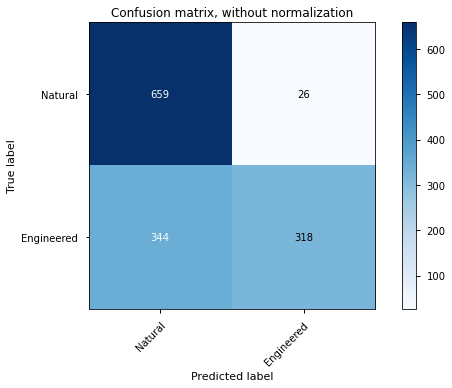

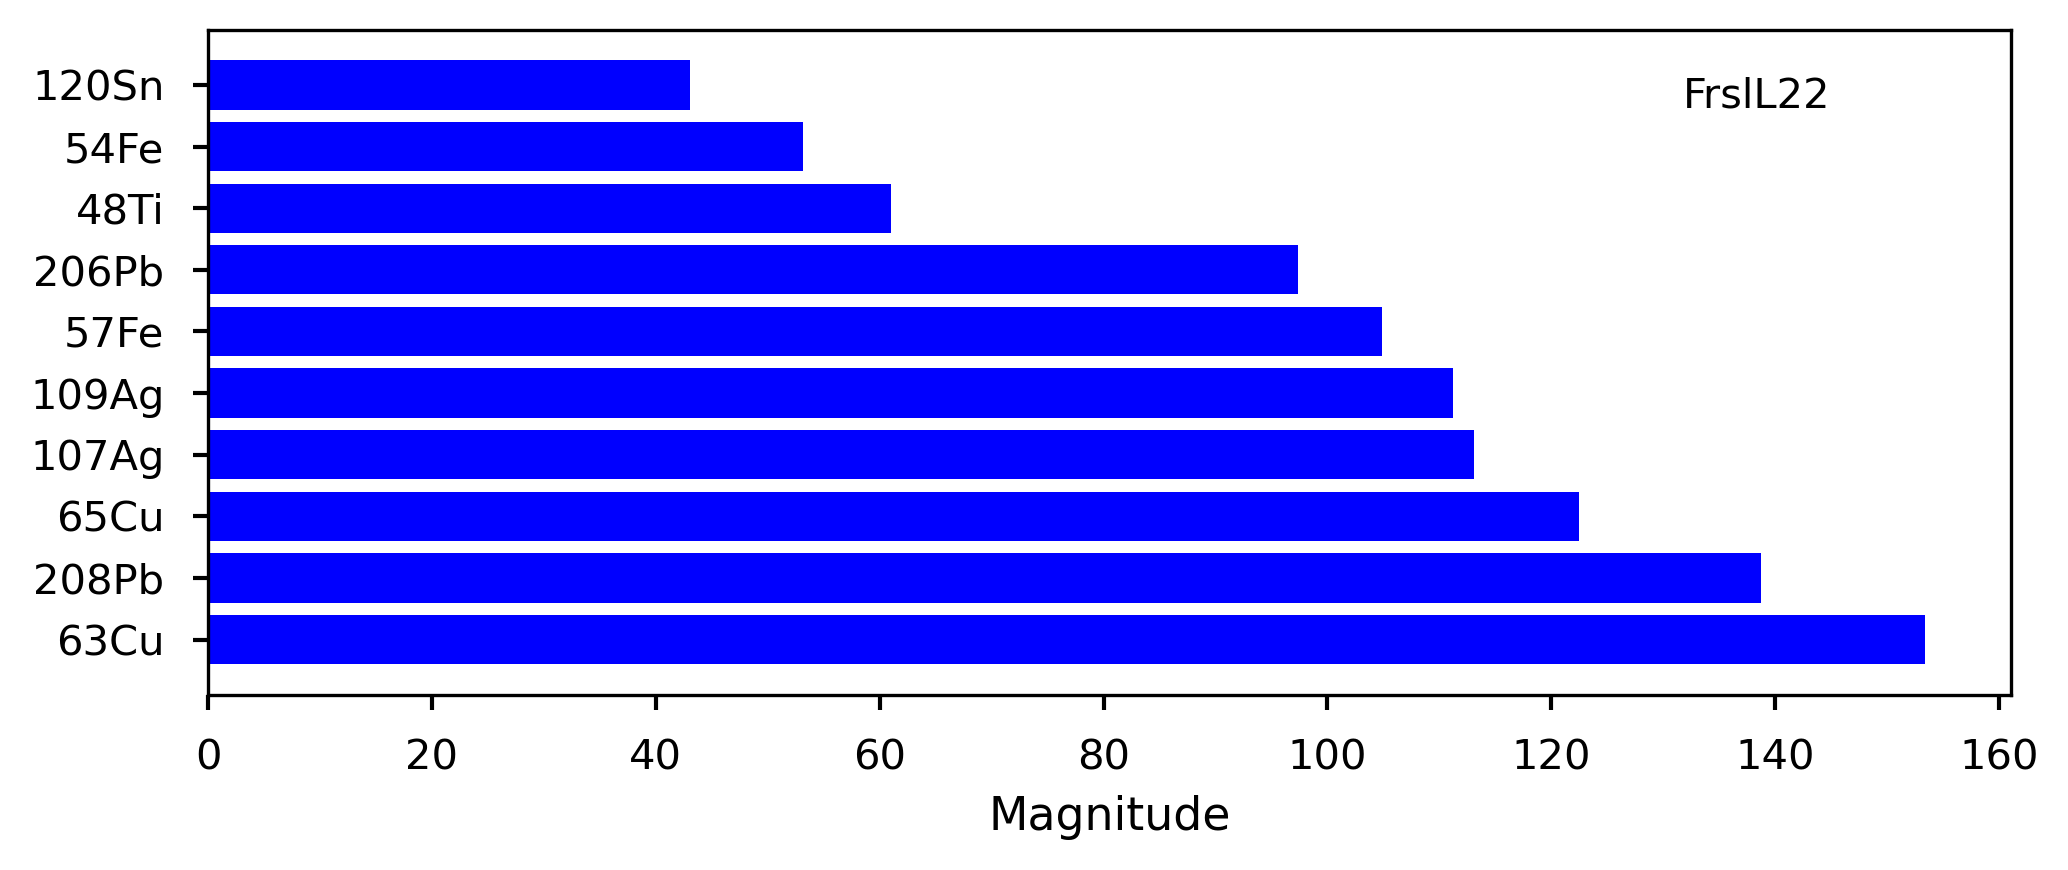

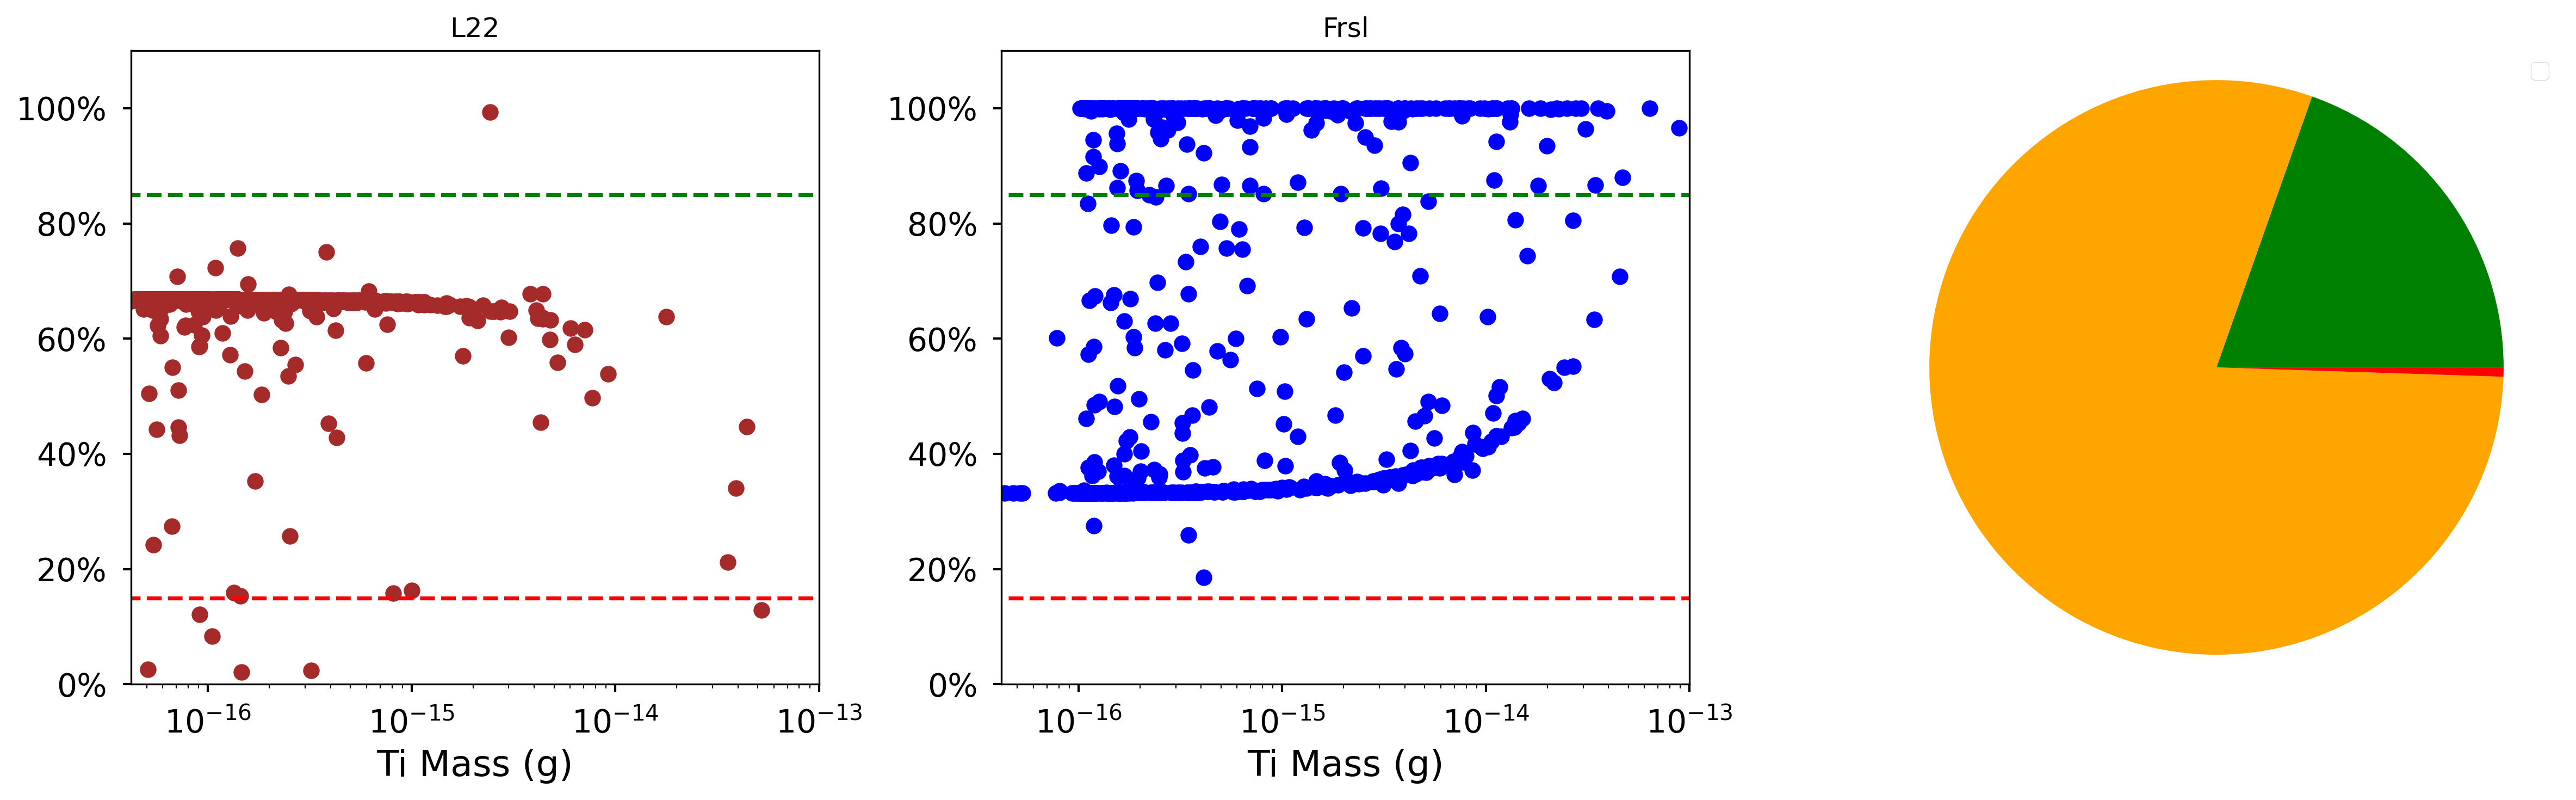

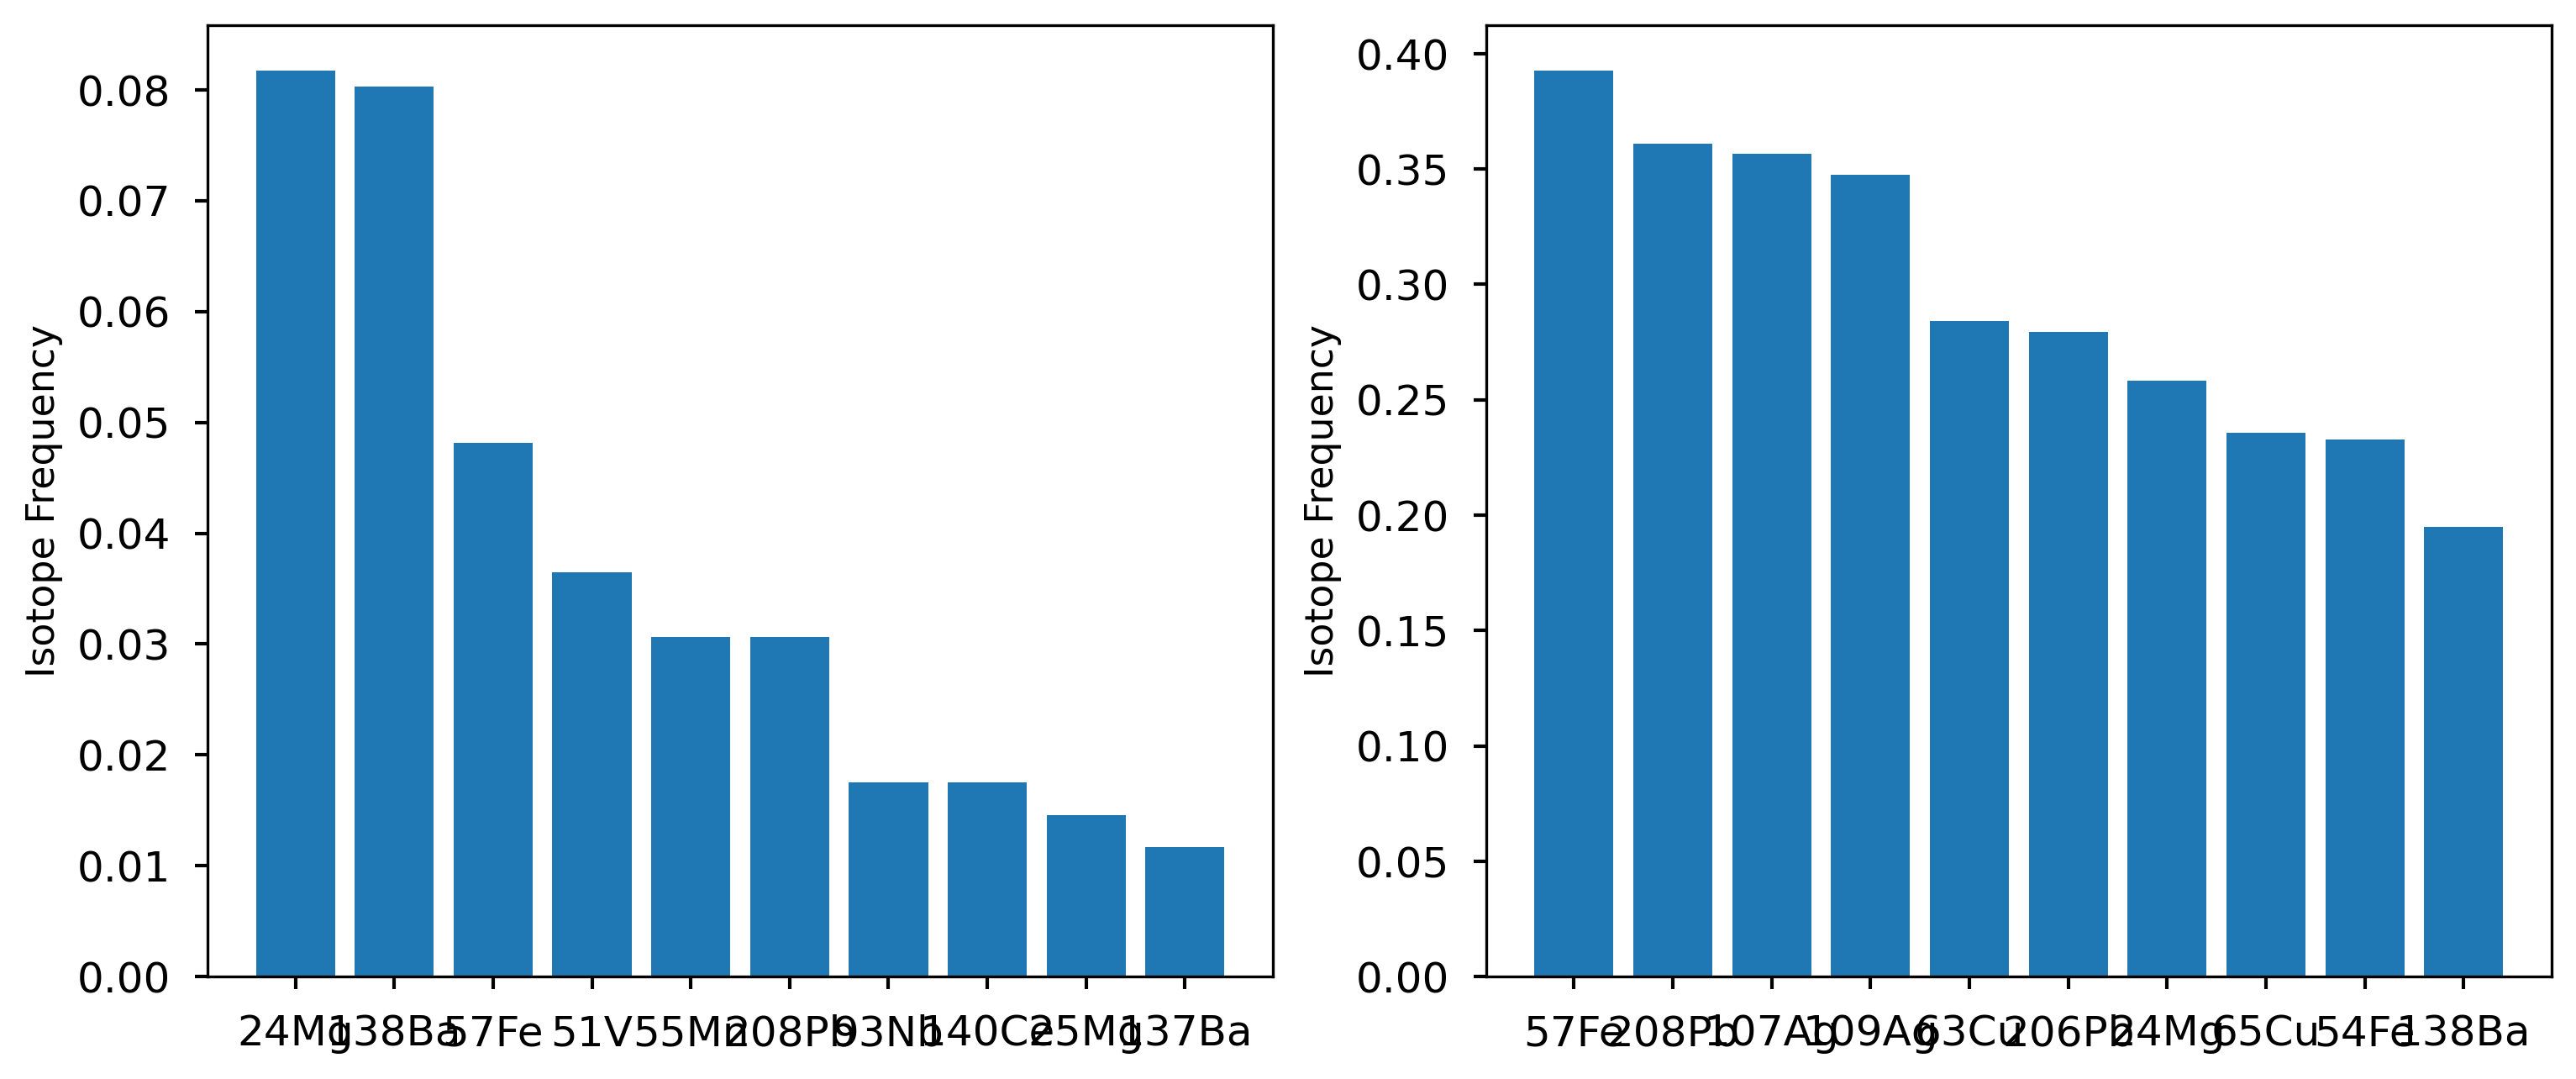

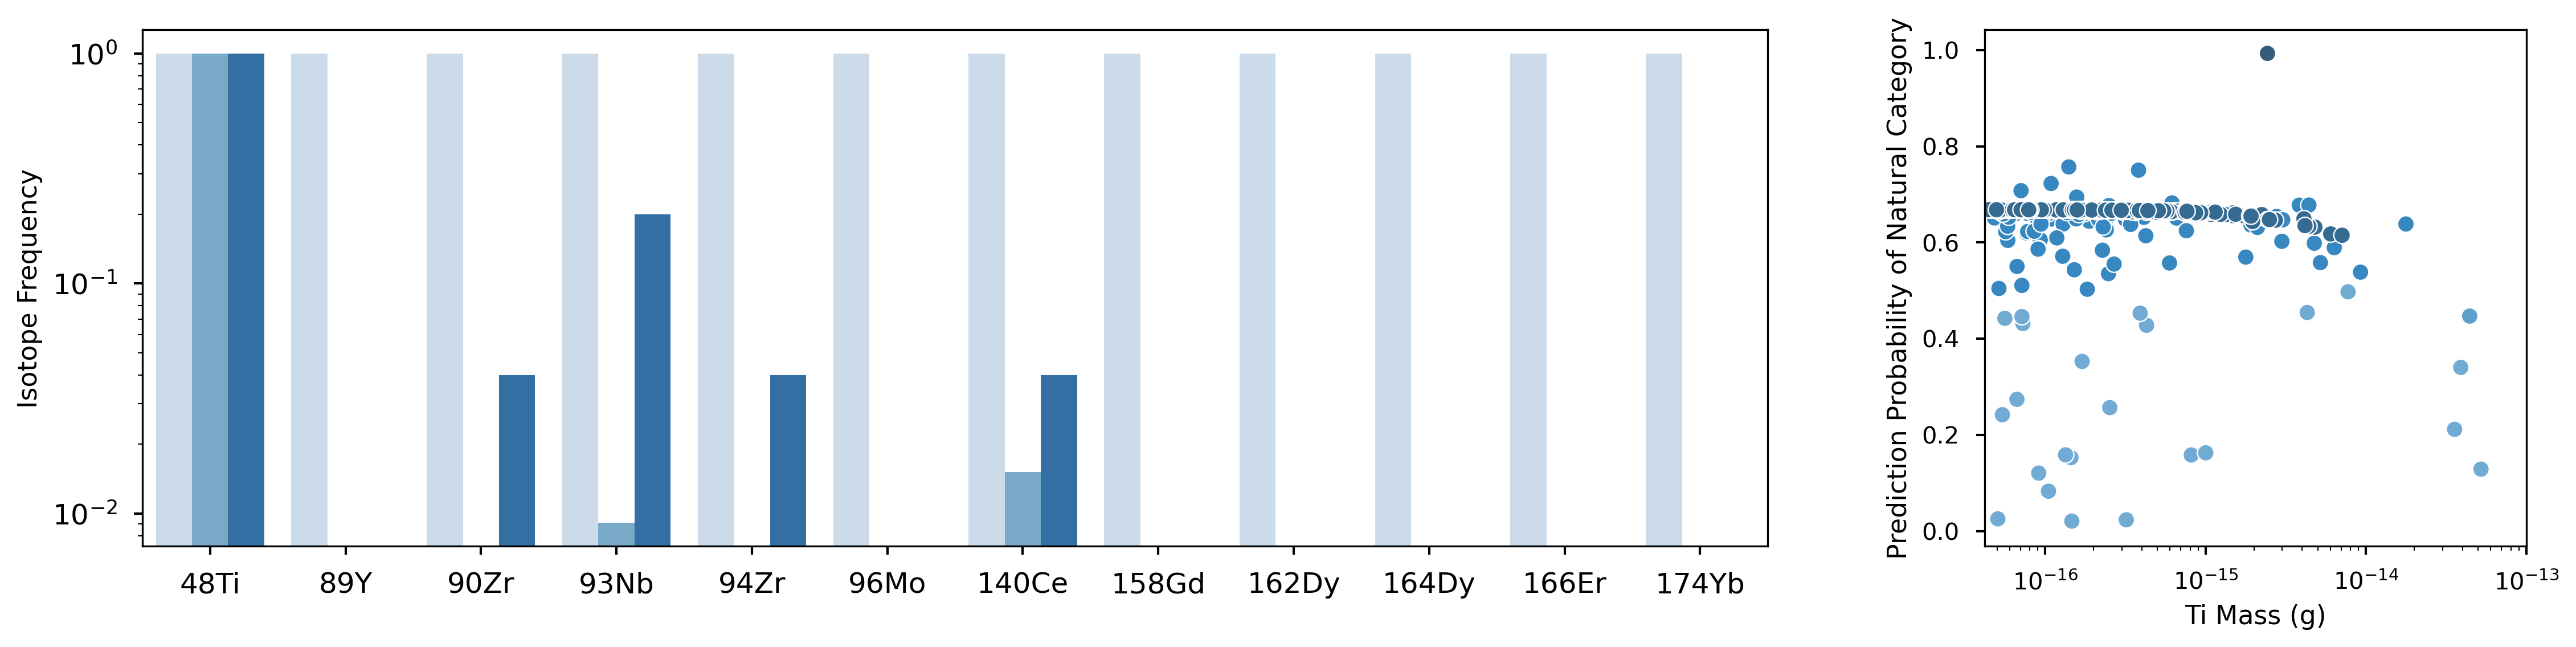

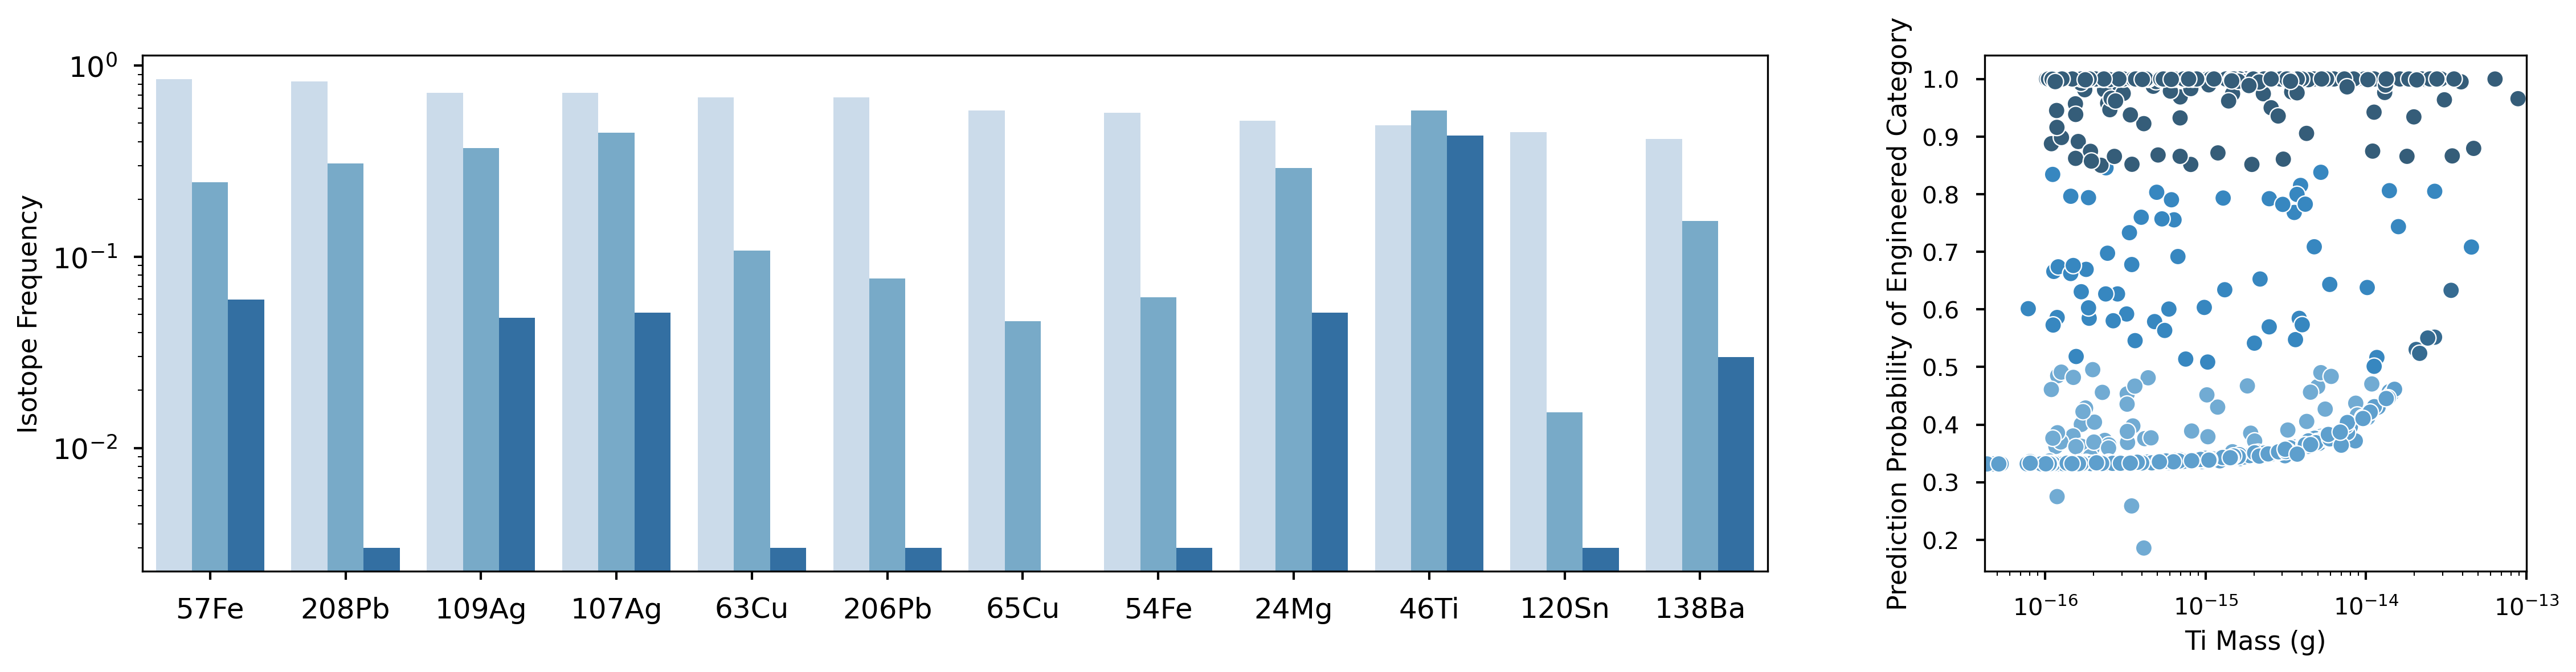

In [8]:
mltrain.MLsimulation(fullset[2], mixkeys[2], labels1[2], 700, 0.001, natkeysexpand[2], engkeysexpand[2], 0, 0)

In [9]:
mixkeys

['FrslFrso',
 'FrslAz',
 'FrslL22',
 'Ti100Frso',
 'Ti100Az',
 'Ti100L22',
 'Ti30Frso',
 'Ti30Az',
 'Ti30L22']

## Save variables for prediction

Ti100L22 Empty DataFrame
Columns: []
Index: [Engineered, Natural]
Model: standardscaler->featureunion->logisticregressioncv


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init

Accuracy: [0.8808, 0.9141] (0.8975 +/- 0.0167)


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init

Confusion matrix, without normalization
[[3053  146]
 [ 503 2639]]
L22 58.53073333601723 36.204197726356604
Ti100 160.10774429297942 60.32956451717983
L22 0.8046264457643013
Ti100 0.9840865690642903
Total correct = 0.41949219366030593
Total Engineered Correct =0.6594525779758116
Total uncertain = 0.5704147610786943
Total misclassified = 0.010093045260999842


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an e

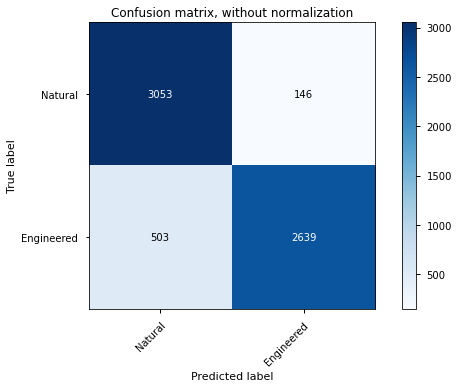

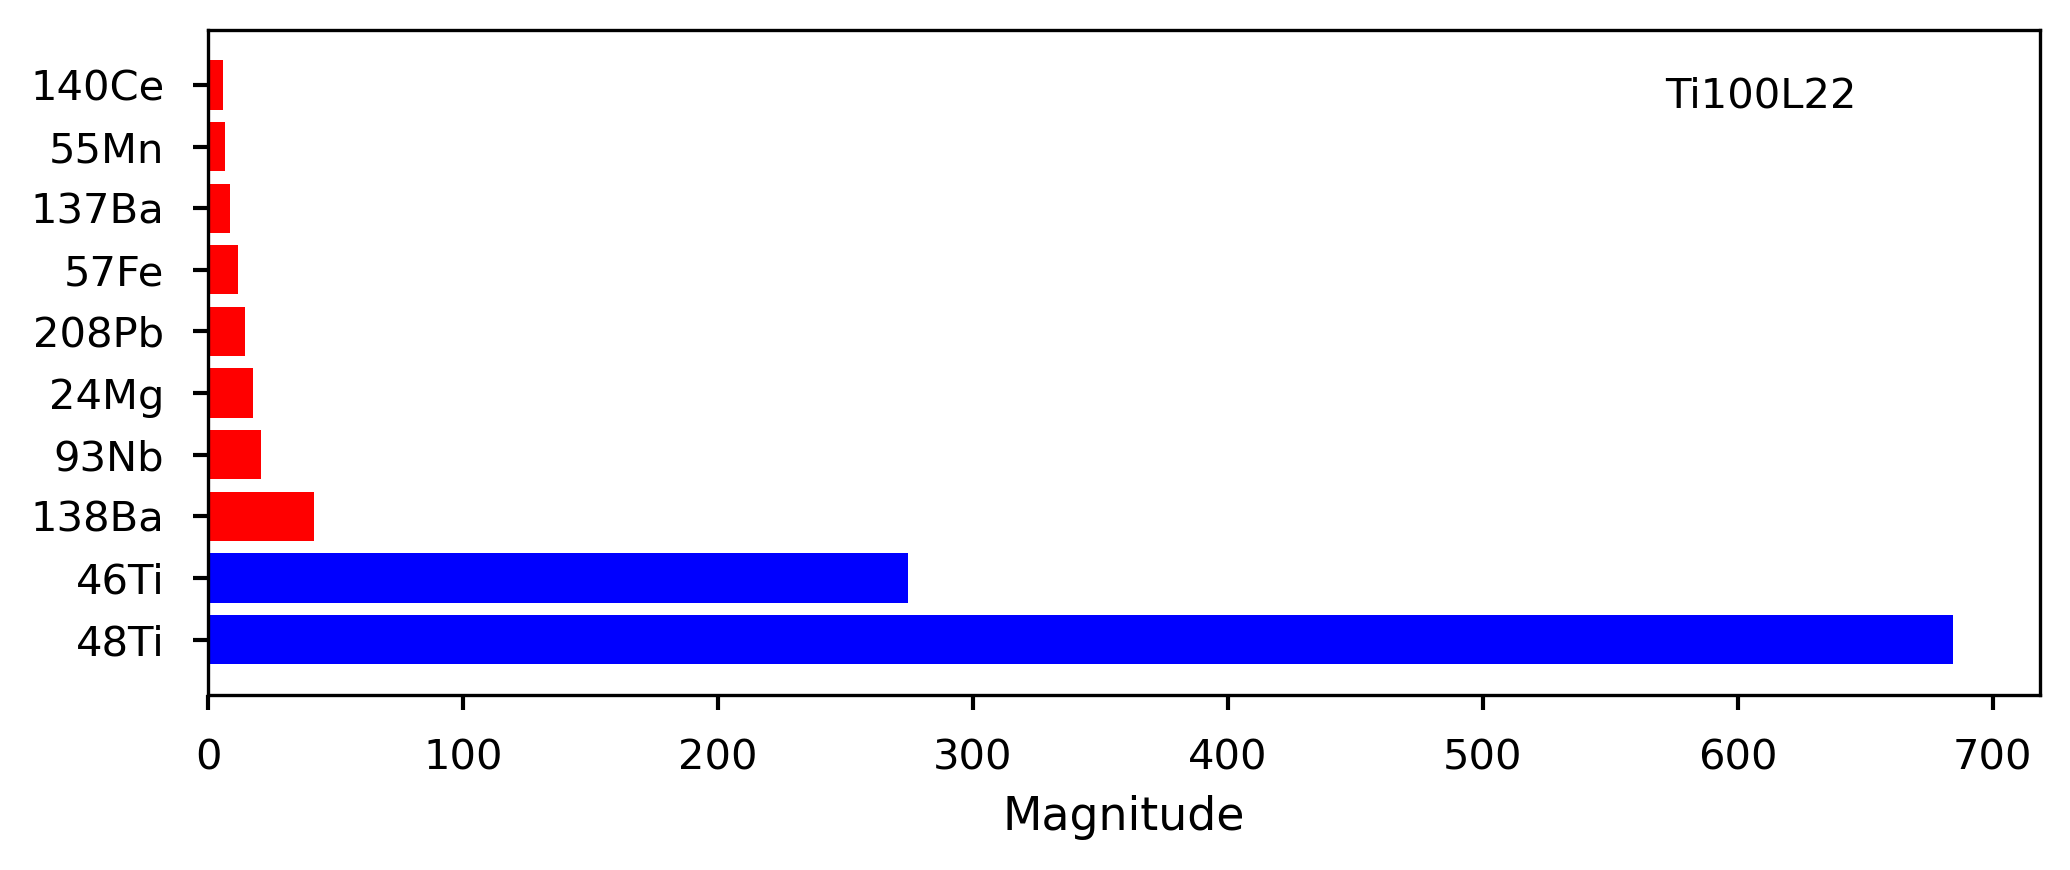

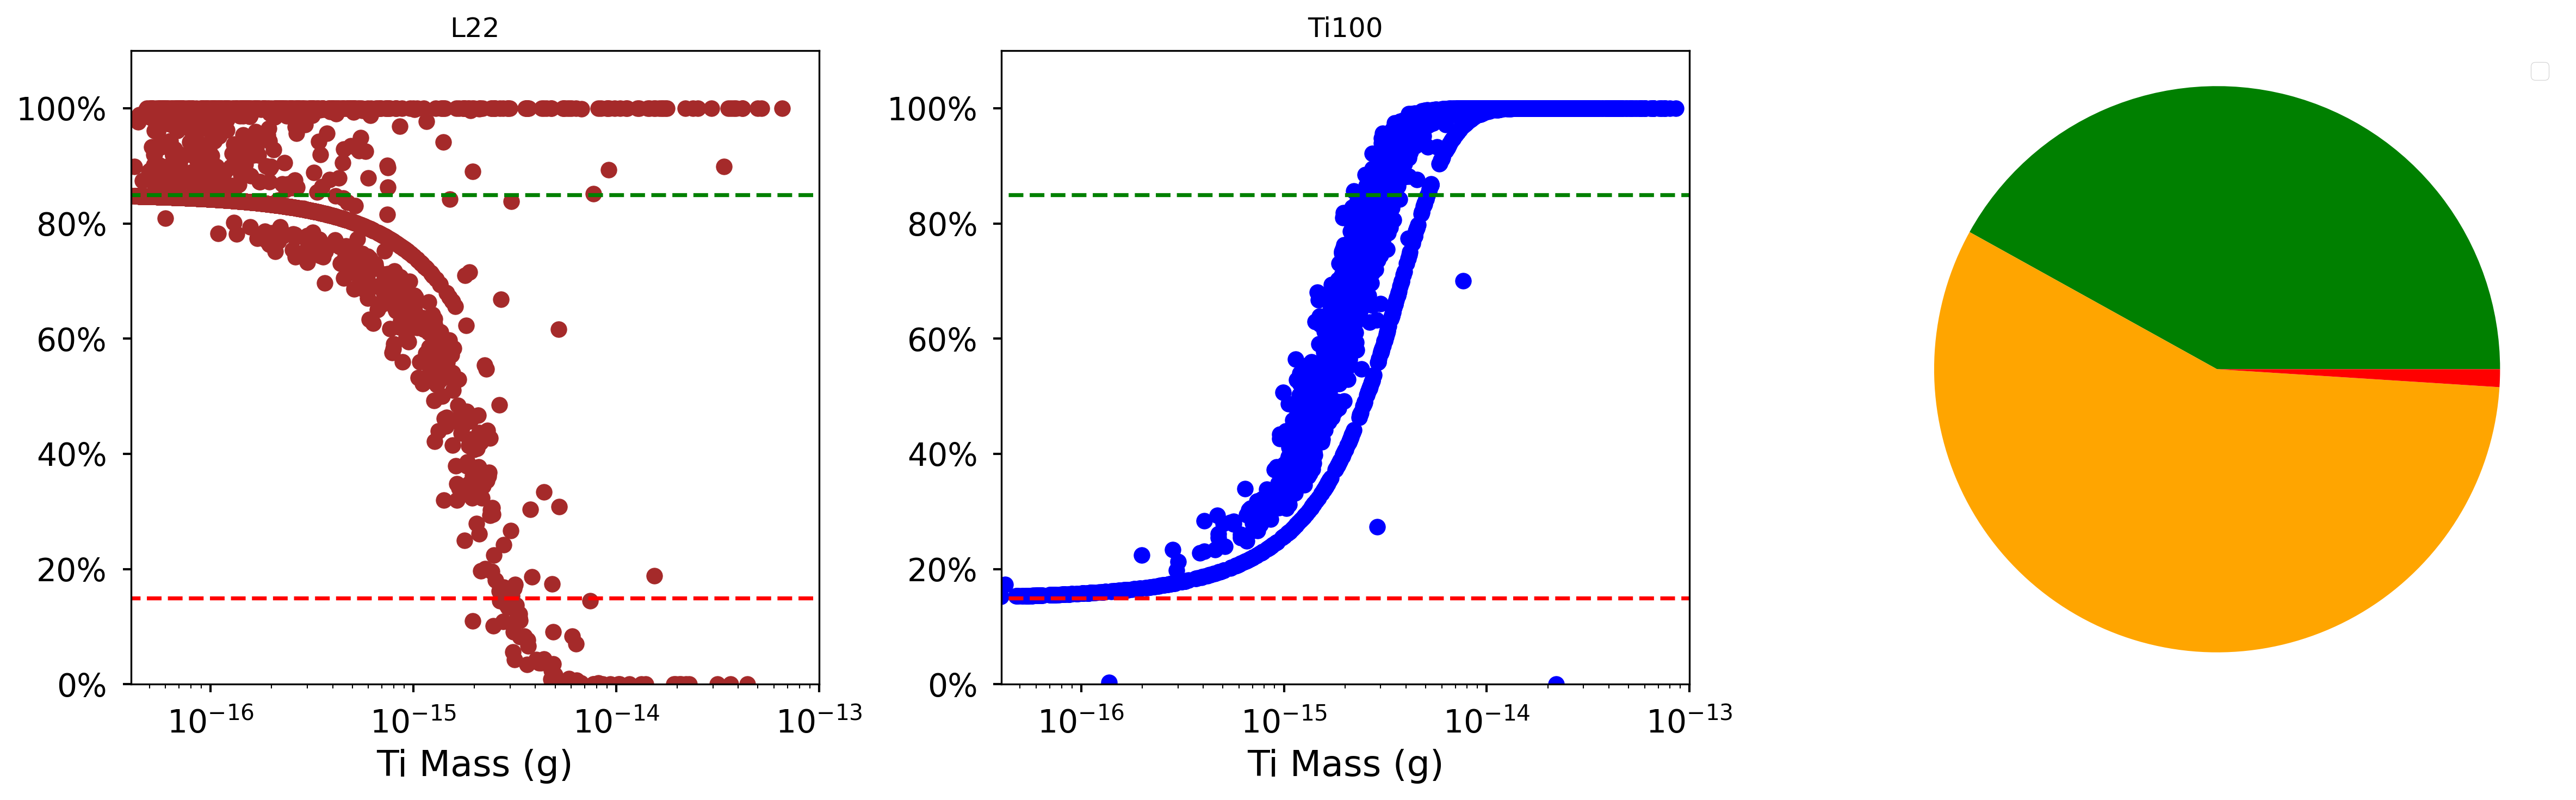

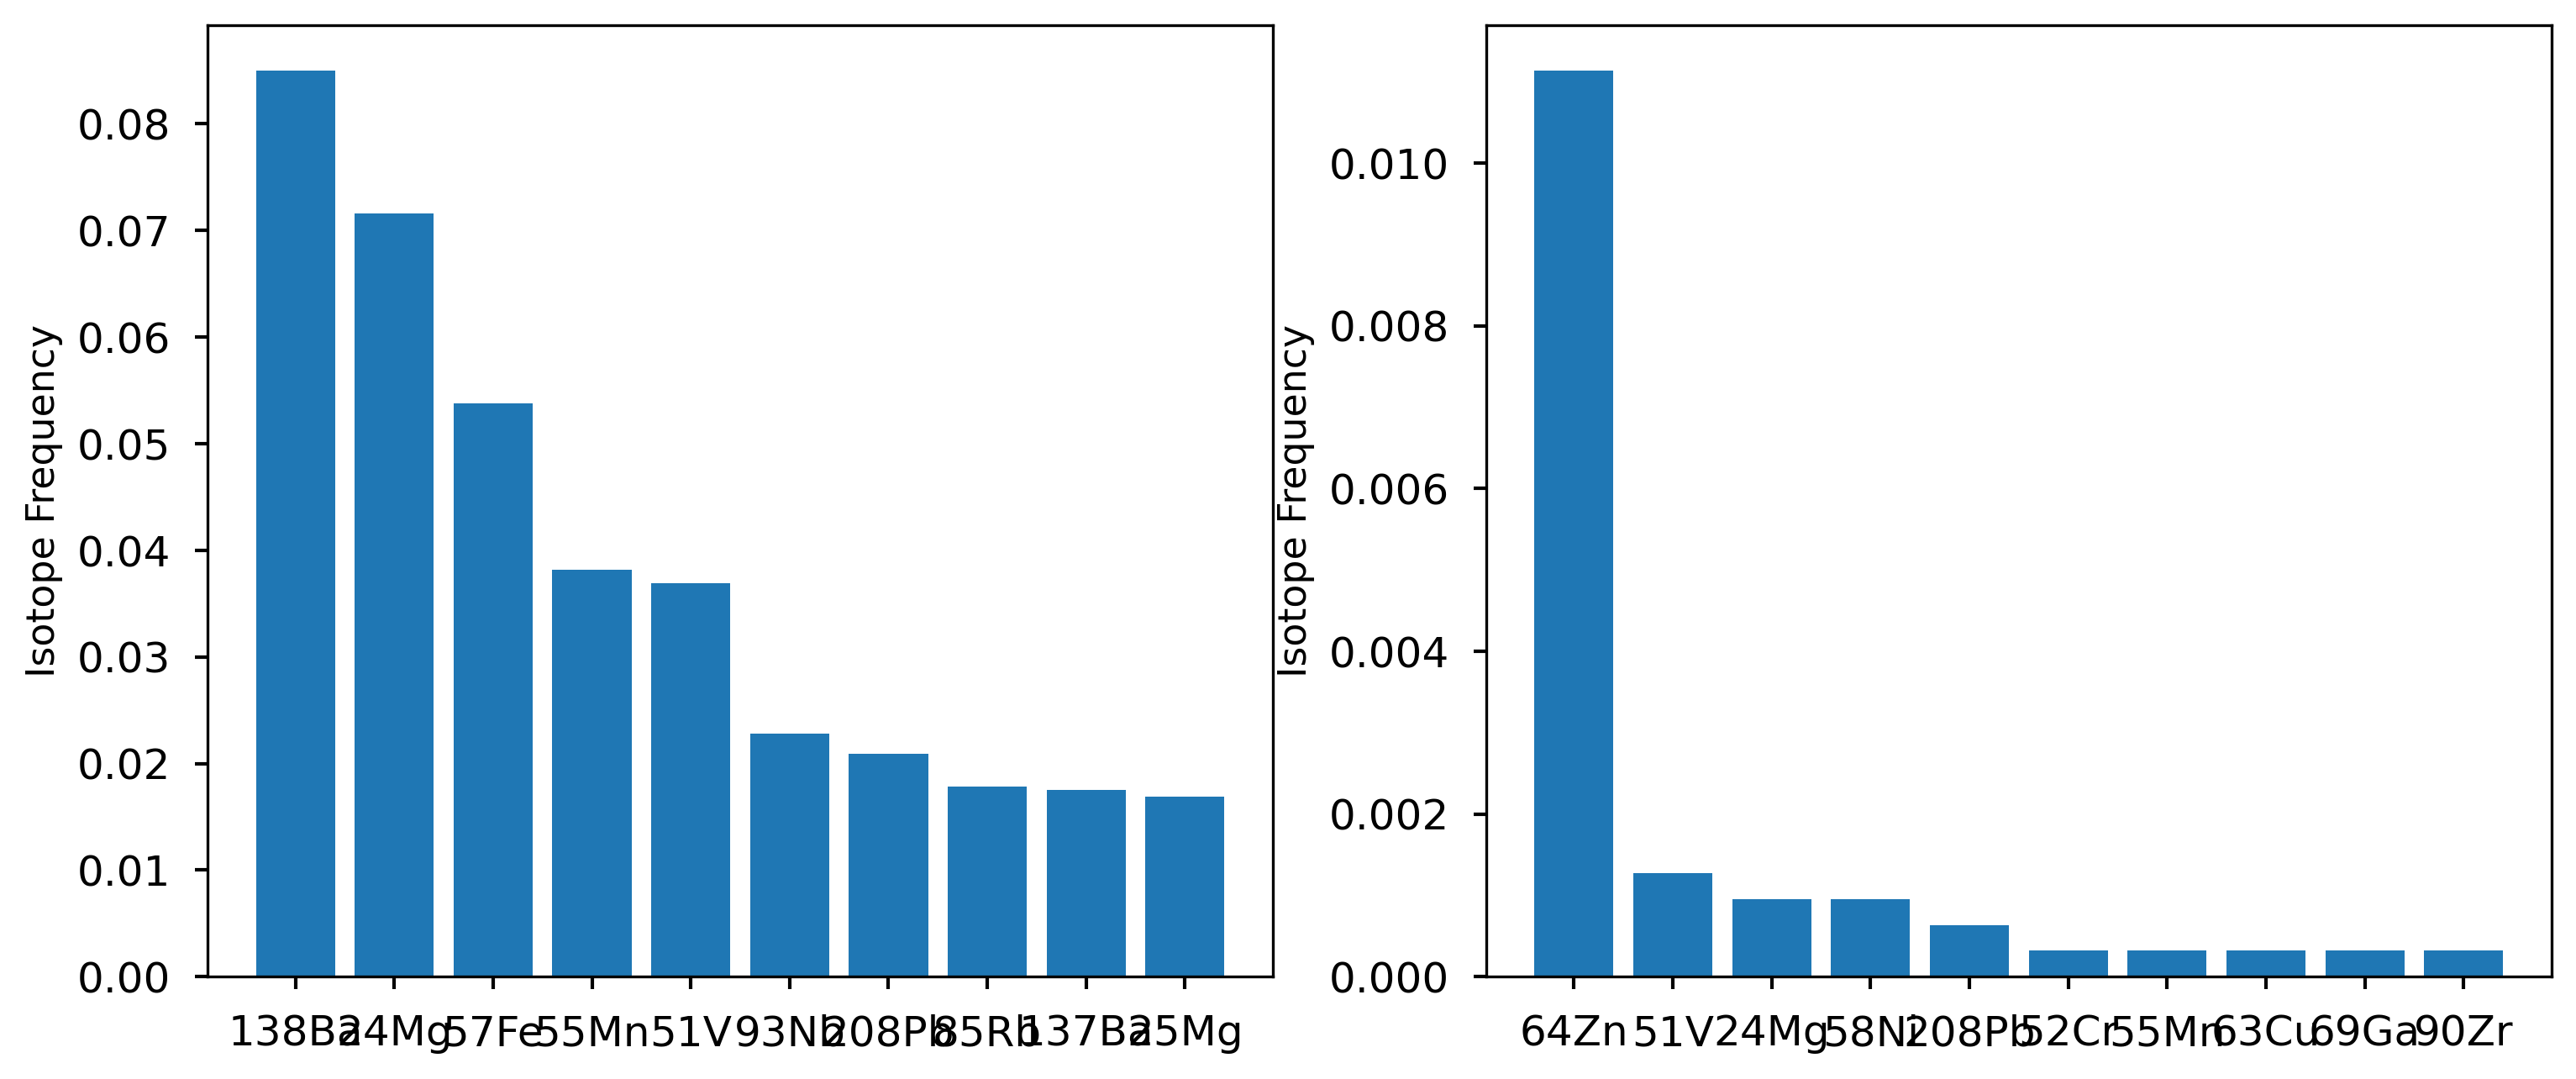

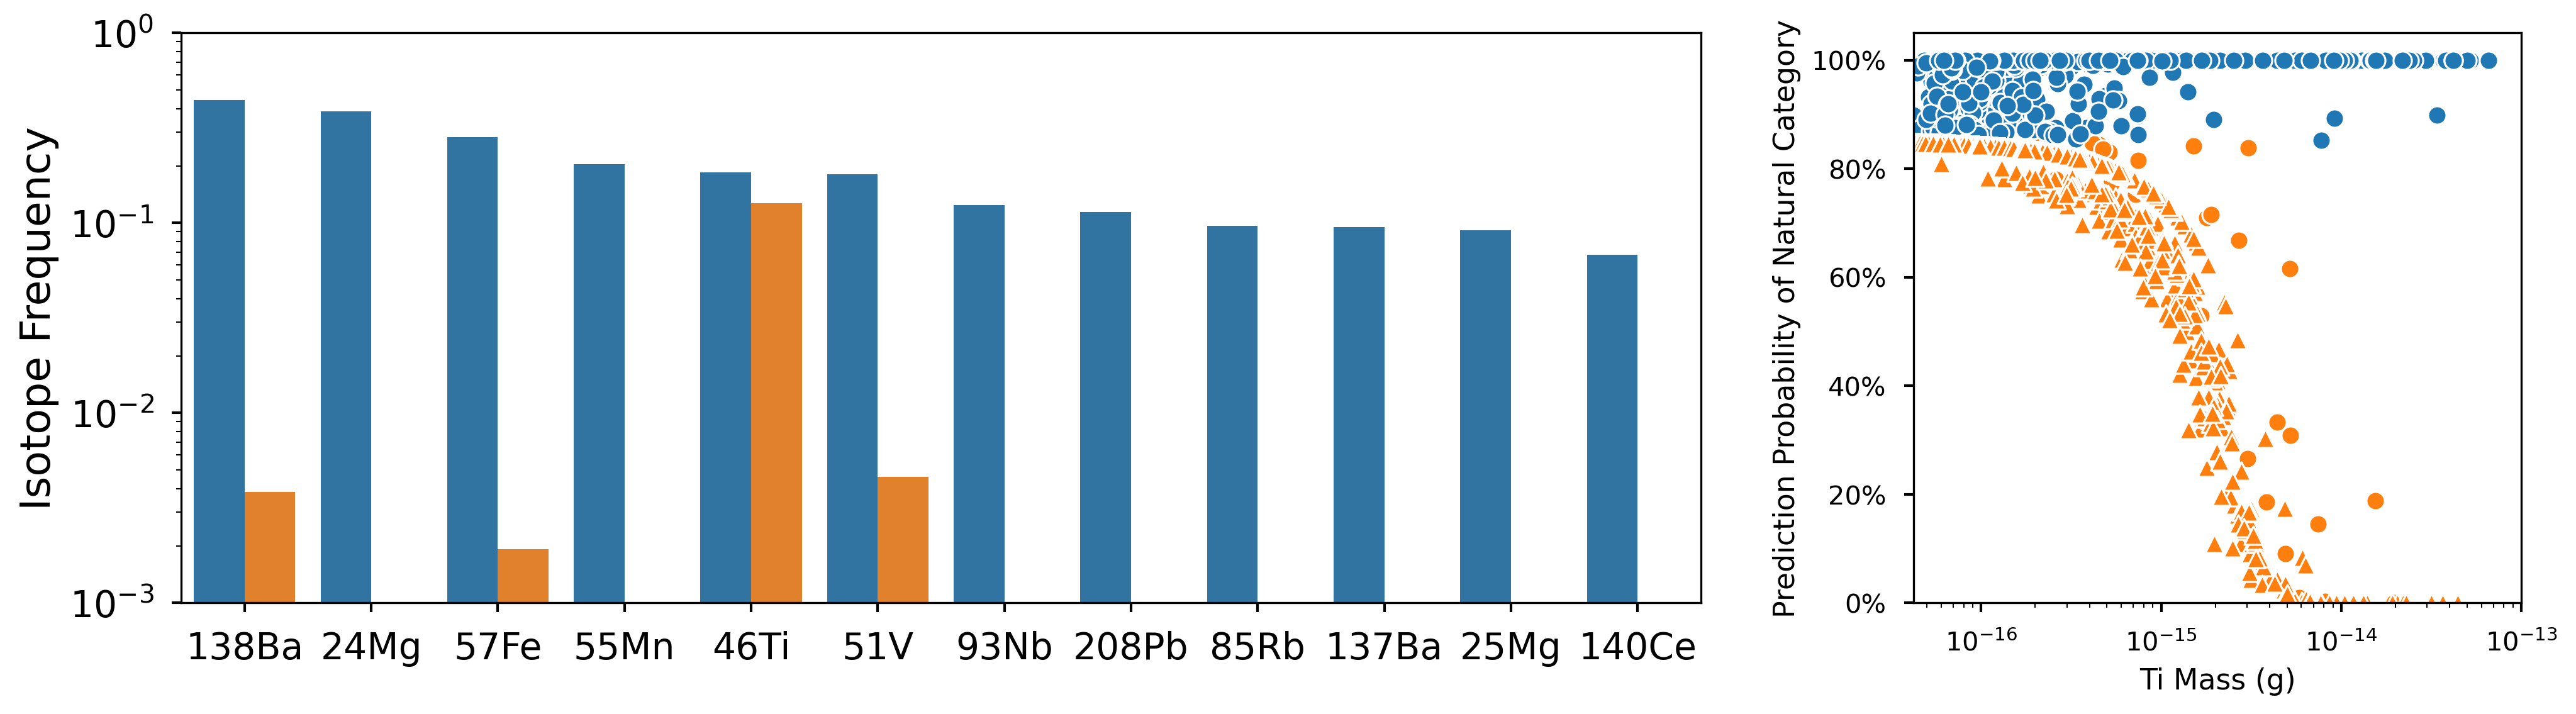

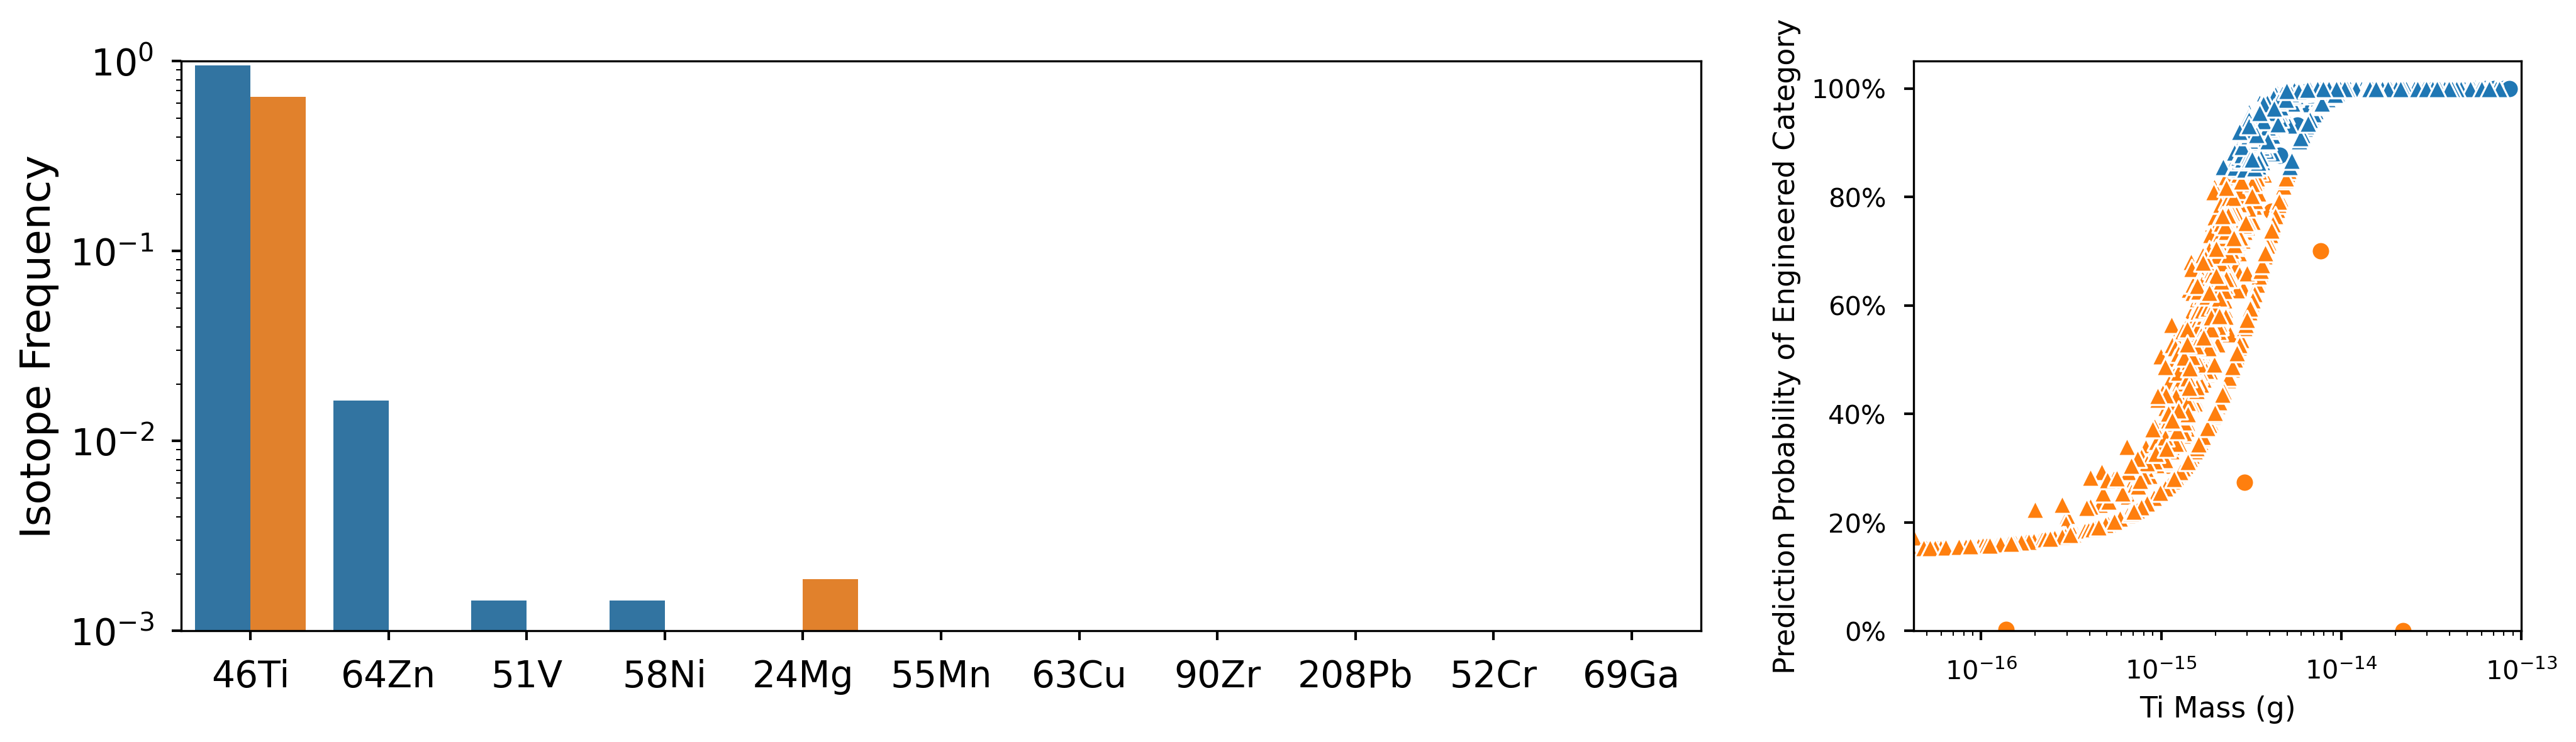

In [10]:
clf, df_with_prob, multipliedcomps, df, labels = mltrain.MLsimulation(fullset[5], mixkeys[5], labels1[5], 700, 0.001, natkeysexpand[5], engkeysexpand[5], 1, 1, returns = True)

# Predicting on unkown samples

In [21]:
#wrapping multiple dataframes into one
def wrapper(datapath, DROPCOLS):
    empty = []
    label = []
    for i in glob.glob(datapath + '*'):
        print(i)
        empty.append(read_csv(i, DROPCOLS)[0])
        label.append(read_csv(i, DROPCOLS)[1])
    return empty, label

def categories(sample, analyte, perc1, perc2):
    sampleperc1 = len(sample[sample ['p_engineered'] >= perc1])/len(sample)
    sampleperc2 = len(sample[sample ['p_engineered'] >= perc2])/len(sample)
    #sampleperc1 = sampleperc1 - sampleperc2
    return sampleperc1, sampleperc2

#Particle concentration with the necessary inputs
def Particleconc(dataframe, analyte, Flowrate, nebefficiency, timeacq, numberruns,  volume = None, Soilmass = None, dilution = 1):
    Count = dataframe[dataframe[analyte].notnull()].count()[analyte]
    Particleconc = Count*timeacq/(numberruns*nebefficiency*Flowrate)
    print('{:0.2e}'.format(Particleconc*dilution * volume/Soilmass))
    try:
        return Particleconc*dilution * volume/Soilmass
    except TypeError:
        return Particleconc
    
def categories(sample, analyte, perc1, perc2):
    sampleperc1 = len(sample[sample ['p_engineered'] >= perc1])/len(sample)
    sampleperc2 = len(sample[sample ['p_engineered'] >= perc2])/len(sample)
    return sampleperc1, sampleperc2

DROPCOLS = ['23Na_mass_g', '28Si_mass_g', '27Al_mass_g', '31P_mass_g', '32S_mass_g', '34S_mass_g', '39K_mass_g', '40Ca_mass_g', '44Ca_mass_g',
            '78Se_mass_g', '80Se_mass_g', '56Fe_mass_g', '106Pd_mass_g', '209Bi_mass_g', '238U_mass_g']
#Data set run from 6_07_19
Lufabl, lufabl_label = sphandle.wrapper('sample_data/Predict files/All_Quantified__LufaBlank', DROPCOLS)
Lufa70, lufa70_label = sphandle.wrapper('sample_data/Predict files/All_Quantified__70PPM', DROPCOLS)
Lufa700, lufa700_label =  sphandle.wrapper('sample_data/Predict files/All_Quantified__700PPM', DROPCOLS)
Lufa7k, lufa7k_label = sphandle.wrapper('sample_data/Predict files/All_Quantified__7000PPM', DROPCOLS)
Lufa = [Lufabl, Lufa70[0:3], Lufa70[3:6], Lufa700[0:3], Lufa700[3:6], Lufa7k[0:3], Lufa7k[3:6]]

for i in Lufa:
    for j in i:
        j = isotope_particle(j, '48Ti')
    
    
def probability(sample):    
    y_pred = clf.predict(sample)
    y_prob = clf.predict_proba(sample)

    probd = pd.DataFrame([[l, p_eng, p_nat] for l, (p_eng, p_nat) in zip(y_pred, y_prob)],
                           columns=['label', 'p_engineered', 'p_natural'])

    sample = pd.concat([sample.reset_index(drop=True), probd], axis=1)
    return y_pred, y_prob, probd, sample

variablesLufa = [[probability(abs(i)) for i in j] for j in Lufa]

overallsampledata = []
for i in variablesLufa:
    sampledata = []
    for j in i:
        sampledata.append(categories(j[3], '48Ti', 0.5, 0.85))
    overallsampledata.append(sampledata)
    
mean50 = []
mean85 = []
stdev50 = []
stdev85= []
for i in overallsampledata:
    k = np.array(i)
    mean50.append(k[:,0].mean())
    stdev50.append(k[:,0].std())
    mean85.append(k[:,1].mean())
    stdev85.append(k[:,1].std())

sample_data/Predict files\All_Quantified__LufaBlank1.csv
sample_data/Predict files\All_Quantified__LufaBlank2.csv
sample_data/Predict files\All_Quantified__LufaBlank3.csv
sample_data/Predict files\All_Quantified__70PPM1rep.csv
sample_data/Predict files\All_Quantified__70PPM2rep.csv
sample_data/Predict files\All_Quantified__70PPM3rep.csv
sample_data/Predict files\All_Quantified__70PPM_1.csv
sample_data/Predict files\All_Quantified__70PPM_2.csv
sample_data/Predict files\All_Quantified__70PPM_3.csv
sample_data/Predict files\All_Quantified__700PPM1rep.csv
sample_data/Predict files\All_Quantified__700PPM2rep.csv
sample_data/Predict files\All_Quantified__700PPM3rep.csv
sample_data/Predict files\All_Quantified__700PPM_1.csv
sample_data/Predict files\All_Quantified__700PPM_2.csv
sample_data/Predict files\All_Quantified__700PPM_3.csv
sample_data/Predict files\All_Quantified__7000PPM1rep.csv
sample_data/Predict files\All_Quantified__7000PPM2rep.csv
sample_data/Predict files\All_Quantified__7000P

In [22]:

    
samples = [Lufabl, Lufa70[0:3], Lufa70[3:6], Lufa700[0:3], Lufa700[3:6], Lufa7k[0:3], Lufa7k[3:6]]
SampleNames = ['Lufa', '70PPM', '700PPM', '7000PPM']

dosedparticleconc = []
for i in range(0, len(samples)):
    indivsamples = []
    for j in samples[i]:
        if i == 0:
            indivsamples.append(sphandle.Particleconc(j, '48Ti', 0.355, 0.0123, (180*3)/60, 1, 30, 3, dilution = 10**5))
        elif i == 2 or 4 or 6:
            indivsamples.append(sphandle.Particleconc(j, '48Ti', 0.403, 0.0196, (120*3 + 180*3)/60, 1, 30, 3, dilution = 10**6))
        elif i == 1 or 3 or 5:
            indivsamples.append(sphandle.Particleconc(j, '48Ti', 0.403, 0.0196, (120*3 + 180*3)/60, 1, 30, 3, dilution =  10**6))
    dosedparticleconc.append(indivsamples)

1.86e+14
1.86e+14
1.86e+14
1.71e+15
1.71e+15
1.71e+15
1.14e+15
1.14e+15
1.14e+15
1.71e+15
1.71e+15
1.71e+15
1.14e+15
1.14e+15
1.14e+15
1.71e+15
1.71e+15
1.71e+15
1.14e+15
1.14e+15
1.14e+15


In [23]:
engineeredNPconc = []
for i in range(0, len(overallsampledata)):
    engineeredNPconc.append([np.array(overallsampledata[i])[:,0] * dosedparticleconc[i], np.array(overallsampledata[i])[:,1] * dosedparticleconc[i]])

In [24]:
engineeredNPconc50mean = []
engineeredNPconc50stdev = []
engineeredNPconc85mean = []
engineeredNPconc85stdev = []
for i in range(0, len(overallsampledata)):
    engineeredNPconc50mean.append(engineeredNPconc[i][0].mean())
    engineeredNPconc50stdev.append(engineeredNPconc[i][0].std())
    engineeredNPconc85mean.append(engineeredNPconc[i][1].mean())
    engineeredNPconc85stdev.append(engineeredNPconc[i][1].std())
    
totalconcmean = []
totalconcstd = []
for i in range(0, len(overallsampledata)):
    totalconcmean.append(np.array(dosedparticleconc[i]).mean())
    totalconcstd.append(np.array(dosedparticleconc[i]).std())

Text(0, 0.5, 'Ti-Particle Concentration (Number of particles per g of soil)')

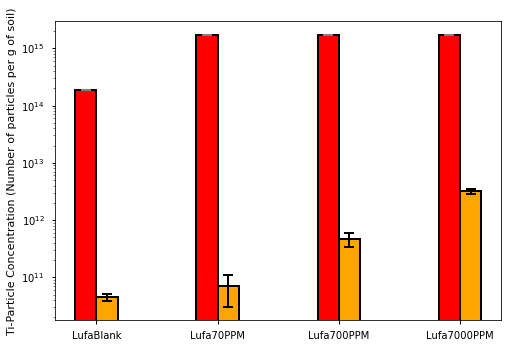

In [25]:
ind = np.array([0, 2, 4])
width = 0.35

errorkw1 = dict(ecolor = 'gray', lw = 2, capsize=5, capthick=2)
errorkw2 = dict(ecolor = 'black', lw = 2, capsize=5, capthick=2)



plt.bar(-.175, totalconcmean[0], width, yerr = totalconcstd[0], color = 'red', edgecolor = 'black', linewidth = 2, 
        error_kw = errorkw1)
plt.bar(.175, engineeredNPconc85mean[0], width, yerr = engineeredNPconc85stdev[0], color = 'orange', edgecolor = 'black', linewidth = 2, 
       error_kw = errorkw2)
plt.bar(ind + 1.825, [totalconcmean[i] for i in [1,3,5]], width, yerr = [totalconcstd[i] for i in [1,3,5]], label = 'rep 1',
        color = 'red', edgecolor = 'black', linewidth = 2, error_kw = errorkw1)
plt.bar(ind + 2.175, [engineeredNPconc85mean[i] for i in [1,3,5]], width, yerr = [engineeredNPconc85stdev[i] for i in [1,3,5]], label = 'rep 1', 
        color = 'orange', edgecolor = 'black', linewidth = 2, error_kw = errorkw2)
plt.yscale('log')
plt.xticks([0, 2, 4, 6], ('LufaBlank', 'Lufa70PPM', 'Lufa700PPM', 'Lufa7000PPM'))
plt.ylabel('Ti-Particle Concentration (Number of particles per g of soil)')
#plt.savefig('../../figsfromscript/predictionoftiparticlesasengineered1trialcor.png', dpi = 500)